# Index Tracking with Gurobi

This python notebook is part of webinar presented by [Finor's](www.finor.tech) team and [Gurobi](www.gurobi.com) and will show two examples of solving an index tracking problem using Gurobi.

The code will:

1. Install all requirements to run the code
1. Import data from yahoo finance for a N number of stocks for index SP100
1. Clean the data:
  - Filter tickers with low number of observations;
  - Calculate returns and reformat to wide (dates as rows, tickers as columns).
  - Separate the data intro training (used for optimization) and testing (used for analyzing results).
3. Set up the optimization problem using gurobi and solve it:
  - Unconstrained model
  - Asset constrained model
4. Analyze results in testing data

The following extra resources are available:

* Link video (TBD)

## Setting up enviroment

In [ ]:
# code requirements (install python modules)
!pip install gurobipy pandas numpy scipy pyarrow fastparquet yfinance sklearn matplotlib sktime

     |████████████████████████████████| 11.5 MB 4.8 MB/s 
     |████████████████████████████████| 1.4 MB 40.9 MB/s 
     |████████████████████████████████| 6.5 MB 20.5 MB/s 
     |████████████████████████████████| 1.6 MB 43.0 MB/s 
     |████████████████████████████████| 134 kB 51.6 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 48.7 MB/s 
     |████████████████████████████████| 3.3 MB 9.8 MB/s 
     |████████████████████████████████| 9.8 MB 41.1 MB/s 
     |████████████████████████████████| 34.5 MB 10 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    

## Unconstrained Index Tracking

$
\begin{align}
& \mbox{Minimize} \; \frac{1}{T} \; \sum_{t = 1}^{T} \left[\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{t,i} - R_{t}\right]^2  \\
& \mbox{Subject to:} \\
& \sum_{i = 1}^{I} w_{i} = 1  \\
& w_i \geq 0 \\
\end{align}
$

**Where**

$
\begin{align}
T &: \text{Number of time periods} \\
I &: \text{Number of assets} \\
w_i  &: \text{Weight of asset i in index} \\
R_{t} &: \text{Returns of tracked index (e.g. SP100) at time t} \\
r_{t,i} &: \text{Return of asset i at time t}
\end{align}
$

### Import raw price data from YahooFinance


In [ ]:
import pandas as pd
import numpy as np
from random import sample, seed

seed(20220223) # seed for reproducibility

mkt_index = "^SP100"  # index used in data
n_assets = 30         # number of assets to sample (full data n_assets = 97)
first_date = "2015-01-01"
last_date = "2022-01-01"

available_tickers = ['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMGN', 'AMT', 'AMZN',
       'AVGO', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BKNG', 'BLK', 'BMY', 'C',
       'CAT', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CRM', 'CSCO',
       'CVS', 'CVX', 'DD', 'DHR', 'DIS', 'DUK', 'EMR', 'EXC', 'F', 'FB', 'FDX',
       'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM',
       'INTC', 'JNJ', 'JPM', 'KO', 'LIN', 'LLY', 'LMT', 'LOW', 'MA', 'MCD',
       'MDLZ', 'MDT', 'MET', 'MMM', 'MO', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX',
       'NKE', 'NVDA', 'ORCL', 'PEP', 'PFE', 'PG', 'PM', 'QCOM', 'RTX', 'SBUX',
       'SO', 'SPG', 'T', 'TGT', 'TMO', 'TMUS', 'TSLA', 'TXN', 'UNH', 'UNP',
       'UPS', 'USB', 'V', 'VZ', 'WBA', 'WFC', 'WMT', 'XOM']

# select n_assets tickers       
sampled_tickers = sample(available_tickers, n_assets)
tickers_to_fetch = sampled_tickers + [mkt_index]

# fetch data from yfinance
import yfinance as yf
import pandas as pd
from multiprocessing import Pool
from itertools import repeat

def get_yf_data(tickers, 
                first_date, 
                last_date,
                n_threads = 1):
    """Fetches YF data for a group of tickers
    
    Parameters
    ----------
    tickers: str
        A vector of tickers to fetch data (see yf site <https://finance.yahoo.com/> for more details).

    first_date: str 
        First date to fetch data. Use ISO format YYYY-MM-DD.

    last_date: str
        Last date to fetch data. Use ISO format YYYY-MM-DD.

    n_threads: int
        Number of threads to use in parallel processing.

    Returns
    -------
    pandas.DataFrame
        A dataframe with prices in the long format with two columns (Adjusted prices and ticker).

    
    """

    # fetch data with multiprocessing
    with Pool(n_threads) as p:
            
        l_prices = p.starmap(get_single_ticker, 
                             zip(tickers, 
                                 repeat(first_date), 
                                 repeat(last_date)))

    # combine all dataframes into a single dataframe
    df_prices = pd.concat(l_prices)
    
    # only keep price, date and ticker
    df_prices = df_prices[["Adj Close", "ticker"]]
    
    return df_prices


def get_single_ticker(ticker, first_date, last_date):
    """Fetch yahoo finance stock data for input ticker 
    
    Parameters
    ----------
        ticker: str
            ticker symbol (e.g. "MSFT").
        first_date: str
            the first date to fecth data in the YYYY-MM-DD format.
        last_date: str
            the first date to fecth data in the YYYY-MM-DD format.
            
        
    Returns
    -------
    pandas.DataFrame
        A pandas dataframe with prices of a single ticker.

    """
    print(f"{ticker} ", end = "\t")
    
    data = yf.download(ticker, 
                       start = first_date,
                       end = last_date,                        
                       group_by="Ticker", 
                       progress = False)
    
    #print(f" [{data.shape[0]}]", end = "\t")
    
    data['ticker'] = ticker
    
    return data


df_prices = get_yf_data(tickers_to_fetch, 
                first_date, 
                last_date,
                n_threads = 5)

print(df_prices)

print(sampled_tickers)


COP 	FDX 	GS 	KO 	TMO 	HON 	              Adj Close  ticker
Date                           
2015-01-02    43.846748     MRK
2015-01-05    44.498436     MRK
2015-01-06    46.246479     MRK
2015-01-07    47.235497     MRK
2015-01-08    48.186192     MRK
...                 ...     ...
2021-12-27  2212.570068  ^SP100
2021-12-28  2209.010010  ^SP100
2021-12-29  2210.100098  ^SP100
2021-12-30  2203.330078  ^SP100
2021-12-31  2194.580078  ^SP100

[54653 rows x 2 columns]
['MRK', 'PFE', 'MA', 'F', 'MET', 'ABBV', 'COP', 'FDX', 'RTX', 'SO', 'PM', 'MS', 'GS', 'KO', 'CRM', 'TSLA', 'EMR', 'DD', 'BLK', 'BAC', 'LIN', 'GD', 'CHTR', 'ACN', 'TMO', 'HON', 'GE', 'UNH', 'AMGN', 'QCOM']


### Clean prices

In [ ]:
def clean_data(df_prices, 
               mkt_symbol,
               thresh_valid_data = 0.95,
               size_train = 0.75):
  """Clean stock price data, removing tickers with low ammount of observations.
    
  Parameters
  ----------
    df_prices : pandas.DataFrame
        A dataframe with prices in the long format
    
    mkt_symbol : str
        The symbol for the market index (e.g. "^GSPC" or "^SP100").
        
    thresh_valid_data: float
        A threshold value (percentage) for keeping tickers with valid date (e.g 0.95).

    size_train: float
        Size in percentage of train piece of data.

  Returns
  -------
    pandas.DataFrame 
      A dataframe with all returns data in the long format.

    pandas.DataFrame 
      A Dataframe with training data.

    pandas.DataFrame 
      A Dataframe with testing data.
  """
  
  # Remove tickers with low data volume
  df_sp500 = df_prices.query("ticker == @mkt_symbol")

  rows_sp500 = df_sp500.shape[0]
  threshold_rows = rows_sp500*thresh_valid_data

  ticker_count = df_prices["ticker"].value_counts()

  valid_tickers = ticker_count[ticker_count >= threshold_rows].index

  idx = df_prices["ticker"].isin(valid_tickers)

  df_prices_cleaned = df_prices[idx]

  print(f"Size original: {df_prices.shape}")
  print(f"Size reduced: {df_prices_cleaned.shape}")

  # change to wide table
  df_prices_pivot = df_prices_cleaned.pivot(
      columns='ticker', 
      values='Adj Close'
      )

  # drop all NAs
  df_prices_pivot.dropna(inplace= True)

  # calculate returns
  df_ret = df_prices_pivot.pct_change().dropna()

  n_obs = df_ret.shape[0]
  ref_dates = df_ret.index
  cut_point = int(n_obs*size_train)
  cut_date = ref_dates[cut_point]

  df_train = df_ret[df_ret.index < cut_date]
  df_test = df_ret[df_ret.index >= cut_date]
    
  return df_ret, df_train, df_test

# get train and test dataframes
r_it, r_train, r_test = clean_data(df_prices, 
               mkt_index,
               thresh_valid_data = 0.95,
               size_train = 0.85)

r_mkt = r_it[mkt_index]

r_it = r_it.drop(mkt_index, axis=1)
r_train = r_train.drop(mkt_index, axis=1)
r_test  = r_test.drop(mkt_index, axis=1)
r_mkt_train = r_mkt[r_train.index]
r_mkt_test = r_mkt[r_test.index]

# sample N tickers
sampled_tickers = sample(
    list(r_it.columns),
    n_assets
    )

r_it = r_it[sampled_tickers]

print(r_it)

Size original: (54653, 2)
Size reduced: (54653, 2)
ticker            GE       MRK       BAC  ...       EMR      CHTR       COP
Date                                      ...                              
2015-01-05 -0.018356  0.014863 -0.029050  ... -0.020554 -0.035631 -0.047592
2015-01-06 -0.021545  0.039283 -0.029919  ... -0.001652 -0.026106 -0.041286
2015-01-07  0.000416  0.021386  0.004745  ... -0.002151  0.003071  0.006674
2015-01-08  0.012043  0.020127  0.020661  ...  0.026206  0.039225  0.024941
2015-01-09 -0.013951 -0.004614 -0.017930  ... -0.015678 -0.005892 -0.000154
...              ...       ...       ...  ...       ...       ...       ...
2021-12-27  0.006596  0.011092  0.004953  ...  0.009750  0.006247  0.028375
2021-12-28  0.007187  0.003134  0.001344  ...  0.007812  0.005273 -0.001229
2021-12-29 -0.005352  0.001823 -0.001566  ...  0.000646  0.000747 -0.002735
2021-12-30 -0.000950  0.002469 -0.002241  ... -0.003120  0.001447 -0.008777
2021-12-31 -0.002429 -0.006482 -0.000

### Setup opt problem

In [ ]:
import gurobipy as gp

# Create an empty model and set name
m_unc = gp.Model('unconstrained_model')

# PARAMETERS 
# w_i: the i_th stock gets a weight w_i
w = pd.Series(m_unc.addVars(sampled_tickers, 
                         lb = 0,
                         ub = 1,
                         vtype = gp.GRB.CONTINUOUS), 
               index=sampled_tickers)

# CONSTRAINTS
# sum(w_i) = 1: portfolio budget constrain (long only)
m_unc.addConstr(w.sum() == 1, 'port_budget')

# SET OBJ FUNCTION
# eps_t = R_{t,i}*w - R_{M,t}
my_error = r_train.dot(w) - r_mkt_train

# set objective function
m_unc.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# set options (see <https://www.gurobi.com/documentation/9.5/refman/parameters.html#sec:Parameters>)
m_unc.setParam('OutputFlag', 0)

print("\nOpt problem is set and ready to optimize")


Restricted license - for non-production use only - expires 2023-10-25

Opt problem is set and ready to optimize


### Solve it!

In [ ]:
# solve it!
m_unc.optimize()

w_hat_unc  = [i.X for i in m_unc.getVars()]

status = m_unc.getAttr("Status")
runtime = m_unc.getAttr("RunTime")

print(f"Solution:") 

for i, i_ticker in enumerate(sampled_tickers):
    print(f"{i_ticker}:\t {w_hat_unc[i]*100:.2f}%")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat_unc)}")

print(f"\nOpt Results:")
print(f"Status={status}")
print(f"RunTime={runtime}")

Solution:
GE:	 0.74%
MRK:	 2.85%
BAC:	 1.15%
SO:	 3.97%
LIN:	 2.90%
HON:	 1.71%
PFE:	 5.37%
KO:	 7.19%
F:	 0.00%
UNH:	 4.84%
ABBV:	 1.47%
QCOM:	 5.19%
BLK:	 3.15%
RTX:	 0.00%
ACN:	 8.27%
DD:	 2.01%
TMO:	 6.55%
AMGN:	 6.03%
MS:	 0.00%
MA:	 8.50%
TSLA:	 1.43%
CRM:	 5.55%
MET:	 0.00%
PM:	 4.03%
GS:	 7.07%
FDX:	 3.46%
GD:	 0.29%
EMR:	 0.00%
CHTR:	 4.38%
COP:	 1.93%

checking constraints:
sum(w) = 1.0000000000000027

Opt Results:
Status=2
RunTime=0.021876096725463867


### Results

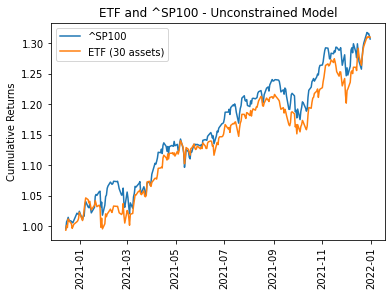

In [ ]:
# check out of sample plot
import matplotlib.pyplot as plt

def plot_index(w_hat, r_test, r_mkt_test, 
               title, etf_label):
  
  r_hat = r_test[sampled_tickers].dot(w_hat)

  cumret_r = np.cumprod(1+ r_hat)
  cumret_mkt = np.cumprod(1+ r_mkt_test)

  fig, ax = plt.subplots()
  ax.plot(cumret_mkt.index,
          cumret_mkt, 
        label = mkt_index)

  ax.plot(cumret_r.index,
          cumret_r,
        label = etf_label)

  ax.legend()
  ax.set_title(title)
  ax.set_xlabel('')
  ax.set_ylabel('Cumulative Returns')

  plt.xticks(rotation = 90)

  plt.show()

plot_index(w_hat_unc, r_test, r_mkt_test,
           f'ETF and {mkt_index} - Unconstrained Model',
           f"ETF ({n_assets} assets)")

## Asset constrained index tracking

$
\begin{align}
& \mbox{Minimize} \; \frac{1}{T} \; \sum_{t = 1}^{T} \left(\sum_{i = 1}^{I} \; w_{i} \: \times \: r_{t,i} - R_{t}\right)^2 \\
& \mbox{Subject to:} \nonumber \\
& \sum_{i = 1}^{I} w_{i} = 1  \\
& \sum_{i = 1}^{I} z_{i} \leq K  \\
& w_i \geq 0  \\
& w_i \leq z_i  \\
& \sum _i ^I z_i \leq K \\
& z_i \in {0, 1} 
\end{align}
$

Where

$
\begin{align}
w_i  &: \text{Weight of asset i in index} \\
z_i &: \text{Binary variable (0, 1) that decides wheter asset i is in the  portfolio} \\
K &: \text{Maximum number of assets to choose} \\
R_{t} &: \text{Returns of tracked index (e.g. SP500) at time t} \\
r_{t,i} &: \text{Return of asset i at time t}
\end{align}
$

### Set opt problem

In [ ]:
# Create an empty model
m_const = gp.Model('asset_contrained_model')

# PARAMETERS 

K = 10 # max number of assets in portfolio

# w_i: the i_th stock gets a weight w_i
w = pd.Series(m_const.addVars(sampled_tickers, 
                         lb = 0,
                         ub = 1,
                         vtype = gp.GRB.CONTINUOUS), 
               index=sampled_tickers)

# [NEW] z_i: the i_th stock gets a binary z_i
z = pd.Series(m_const.addVars(sampled_tickers,
                        vtype = gp.GRB.BINARY),
                index=sampled_tickers)

# CONSTRAINTS

# sum(w_i) = 1: portfolio budget constrain (long only)
m_const.addConstr(w.sum() == 1, 'port_budget')

# [NEW]  w_i <= z_i: restrictions of values of w_i so take it chose particular tickers
for i_ticker in sampled_tickers:
    m_const.addConstr(w[i_ticker] <= z[i_ticker], 
                f'dummy_restriction_{i_ticker}')

# [NEW] sum(z_i) <= max_assets: number of assets constraint
m_const.addConstr(z.sum() <= K, 'max_assets_restriction')

# eps_t = R_{i,t}*w - R_{M,t}
my_error = r_it.dot(w) - r_mkt

# set objective function
m_const.setObjective(
    gp.quicksum(my_error.pow(2)), 
    gp.GRB.MINIMIZE)     

# Set options 
m_const.setParam('OutputFlag', 1)
m_const.setParam('TimeLimit', 60*5) # in secs
m_const.setParam('BranchDir', 1)
m_const.setParam('Heuristics', 0)
m_const.setParam('MIPFocus', 2)
m_const.setParam('GomoryPasses', 0)

print("\tOpt problem is set and ready to optimize")

Set parameter TimeLimit to value 300
Set parameter BranchDir to value 1
Set parameter Heuristics to value 0
Set parameter MIPFocus to value 2
Set parameter GomoryPasses to value 0
	Opt problem is set and ready to optimize


### Solve it!

In [ ]:
# solve it!
m_const.optimize()

# fetch param vector
params = [i.X for i in m_const.getVars()]

# get all variables
n_assets = len(sampled_tickers)
w_hat_const = params[0:n_assets]
z_hat_const = params[n_assets:]
MIPGap = m_const.getAttr('MIPGap')
status = m_const.getAttr("Status")
runtime = m_const.getAttr("RunTime")

print(f"\n\nSolution for w and z:") 

for i, i_ticker in enumerate(sampled_tickers):
    print(f"{i_ticker}:\t w_i = {w_hat_const[i]*100:00.2f}%\tz_i = {z_hat_const[i]}")

# check constraints
print(f"\nchecking constraints:")
print(f"sum(w) = {np.sum(w_hat_const)}")
print(f"sum(z) = {np.sum(z_hat_const)}")
print(f"(w_i <= z_i) : {np.array(w_hat_const) <= np.array(z_hat_const)}")
print(f"MIPGap={MIPGap}")
print(f"Status={status}")
print(f"RunTime={runtime}")


print()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Optimize a model with 32 rows, 60 columns and 120 nonzeros
Model fingerprint: 0x6699c33b
Model has 465 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-01, 6e-01]
  QObjective range [3e-01, 4e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+01]
Presolve time: 0.00s
Presolved: 32 rows, 60 columns, 120 nonzeros
Presolved model has 465 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Root relaxation presolve removed 31 rows and 30 columns
Root relaxation presolved: 1 rows, 30 columns, 30 nonzeros
Root relaxation presolved model has 465 quadratic objective terms


Root relaxation: objective 1.846833e-02, 31 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

### Results

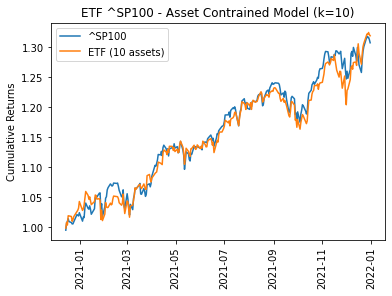

In [ ]:
# check out of sample plot
import matplotlib.pyplot as plt

plot_index(w_hat_const, r_test, r_mkt_test,
           f"ETF {mkt_index} - Asset Contrained Model (k={K})",
           f"ETF ({K} assets)")

## Compare Results

Tracking Errors:
	Unconstrained Model (30 assets):	0.413%
	Asset Constrained Model (10 assets):	0.427%
Max Error:
	Unconstrained Model (30 assets):	2.181%
	Asset Constrained Model (10 assets):	2.245%
Min Error:
	Unconstrained Model (30 assets):	-1.182%
	Asset Constrained Model (10 assets):	-1.260%





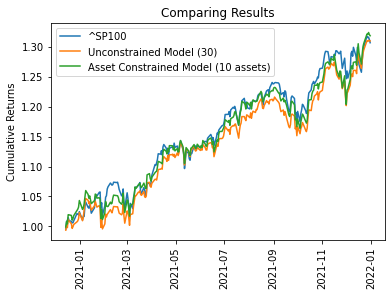

In [ ]:
r_hat_const = r_test[sampled_tickers].dot(w_hat_const)
r_hat_unc =   r_test[sampled_tickers].dot(w_hat_unc)

error_const = r_hat_const - r_mkt_test
error_unc   = r_hat_unc - r_mkt_test

cumret_r_const = np.cumprod(1+ r_hat_const)
cumret_r_unc = np.cumprod(1+ r_hat_unc)
cumret_mkt = np.cumprod(1+ r_mkt_test)

fig, ax = plt.subplots()
ax.plot(cumret_mkt.index,
        cumret_mkt, 
        label = mkt_index)

ax.plot(cumret_r_unc.index,
        cumret_r_unc,
        label = f"Unconstrained Model ({n_assets})")

ax.plot(cumret_r_const.index,
        cumret_r_const,
        label = f"Asset Constrained Model ({K} assets)")

ax.legend()
ax.set_title("Comparing Results")
ax.set_xlabel('')
ax.set_ylabel('Cumulative Returns')
plt.xticks(rotation = 90)

print("Tracking Errors:")
print(f"\tUnconstrained Model ({n_assets} assets):\t{error_unc.std()*100:.3f}%")
print(f"\tAsset Constrained Model ({K} assets):\t{error_const.std()*100:.3f}%")

print("Max Error:")
print(f"\tUnconstrained Model ({n_assets} assets):\t{error_unc.max()*100:.3f}%")
print(f"\tAsset Constrained Model ({K} assets):\t{error_const.max()*100:.3f}%")

print("Min Error:")
print(f"\tUnconstrained Model ({n_assets} assets):\t{error_unc.min()*100:.3f}%")
print(f"\tAsset Constrained Model ({K} assets):\t{error_const.min()*100:.3f}%")

print("\n\n")